In [700]:
from ast import literal_eval
from bs4 import BeautifulSoup
import copy
import csv
import datetime
from datetime import date
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
sns.set_theme()
from sec_edgar_downloader import Downloader
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import naive_bayes, metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
import string
import yfinance as yf

In [469]:
company = ['BABA', 'PDD', 'NTES', 'BIDU', 'JD', 
           'LI', 'TCOM', 'ZTO', 'BEKE', 'XPEV']

In [470]:
#load stock prices and volume from files
def stock_price(ticker):
    df = pd.read_csv(ticker+".csv", index_col="Date")
    df["Returns"] = df['Close'].pct_change(periods=1)
    return df[['Close', 'Returns', 'Volume']]

df_all = []
for c in company:
    df_all.append(stock_price(c))
stock_price_all = pd.concat(df_all, axis=1, keys=company).sort_index()

nasdaq_px = stock_price('nasdaq')

In [471]:
#obtain the current and next trading day
def next_trading_day(date):
    date = date + timedelta(days = 1)
    while True:
        try:
            nasdaq_px.loc[date.strftime("%Y-%m-%d")]['Returns']
            return date
        except:
            date = date + timedelta(days = 1)

def current_trading_day(date):
    while True:
        try:
            nasdaq_px.loc[date.strftime("%Y-%m-%d")]['Returns']
            return date
        except:
            date = date + timedelta(days = 1)

In [472]:
def show_item(ticker, date, item):
    if ticker == "nasdaq":
        return nasdaq_px.loc[date][item]
    else:
        return stock_price_all[ticker].loc[date][item]

In [473]:
tokenizer = TweetTokenizer(preserve_case=False, 
                           strip_handles=True,
                           reduce_len=True)

stopwords_english = stopwords.words('english')

ps = PorterStemmer()

def token_text(text):
    text_tokens = tokenizer.tokenize(text)
    text_clean = []
    for word in text_tokens:
        if (word not in stopwords_english and  
            word not in string.punctuation):  
            text_clean.append(ps.stem(word))
    return text_clean

In [564]:
#input is the raw text of the press release titles and their respective dates
def create_text_df(ticker, text, dates):
    short_list = []
    
    for i in range(len(text)):
        d_t = datetime.strptime(dates[i], '%Y%m%d%H%M%S')
        d = d_t.date()
        if d_t.hour >= 16:
            m = 'post-market'
            app_date = next_trading_day(d)
        else:
            m = 'pre-market'
            app_date = current_trading_day(d)

        app_date_str = datetime.strftime(app_date, "%Y-%m-%d")
        
        v = show_item(ticker, app_date_str, "Volume")        
        r = show_item(ticker, app_date_str, "Returns")
        m_r = show_item('nasdaq', app_date_str, "Returns")
        net_r = r - m_r
        net_r_abs = abs(net_r)
        threshold = 0.02
        if net_r_abs >= threshold:
            material = 1
        else:
            material = 0
        
        short_list.append(
            {'company': ticker,
            'date': d, #datetime format"
             'market': m,
             'app_date': app_date_str, #date only
             'text': text[i],
             'quarterly': re.search("^.* (\w+) Quarter.*(\d\d\d\d).*$", text[i]),
             'token_text': None,
             'volume': v,
            'return': r,
             'market_return': m_r,
             'net_return': net_r,
             'net_return_abs': net_r_abs,
             'material_change': material
            }
        )
    
        short_list[i]['token_text'] = token_text(text[i])
    
    short_list_df = pd.DataFrame.from_dict(short_list)
        
    return short_list_df

In [739]:
def create_freqs(df):
    ys = df['material_change']
    all_text = df['token_text']
    yslist = np.squeeze(ys).tolist()
    freqs = {}

        
    for y, text in zip(yslist, all_text):
        for word in text:
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1 
    return freqs

def create_freqs_alternate(df):
    ys = df['material_change']
    all_text = df['token_text']
    abs_return = df['net_return_abs'] * 100
    yslist = np.squeeze(ys).tolist()
    freqs = {}
    
    n = len(ys)
    
    for i in range(n):
        for word in all_text[i]:
            if ys[i] == 1:
                if (word, 1) in freqs:
                    freqs[(word, 1)] += abs_return[i]
                else:
                    freqs[(word, 1)] = abs_return[i]
            if ys[i] == 0:
                if (word, 0) in freqs:
                    freqs[(word, 0)] += abs_return[i]
                else:
                    freqs[(word, 0)] = abs_return[i]
        
    return freqs

In [476]:
def extract_features(text, freqs, token_text):
    x = np.zeros(3) 
    x[0] = 1 
    for word in token_text:
        try:
            x[1] += freqs[(word, 1)]
        except:
            pass

        try:
            x[2] += freqs[(word, 0)]
        except:
            pass
    x = x[None, :]
    assert(x.shape == (1, 3))
    return x

In [477]:
def open_file(from_file):
    text = []
    with open(from_file, 'r', encoding="utf-8") as f:
        for row in f.readlines():
            text.append(row.replace("\n", ""))
    return text

In [478]:
#Open file for a single company

In [479]:
company_name = 'BABA'

In [480]:
#open text file
from_file = company_name + '_clean.txt'
text = open_file(from_file)

#open date file
from_file = company_name + '_filedate.txt'
dates = open_file(from_file)

In [481]:
assert len(text) == len(dates)

In [482]:
df = create_text_df(company_name, text, dates)
df.sort_values(by="net_return_abs", ascending=False).head(3)

,company,date,market,app_date,text,token_text,volume,return,market_return,net_return,net_return_abs,material_change
155,BABA,2023-03-28,pre-market,2023-03-28,Alibaba Group Announces New Organizational and...,"[alibaba, group, announc, new, organiz, govern...",118875200.0,0.142592,-0.004483,0.147075,0.147075,1
100,BABA,2020-11-03,pre-market,2020-11-03,Ant Group Announces Suspension of Share Listings,"[ant, group, announc, suspens, share, list]",58132500.0,-0.081296,0.018522,-0.099818,0.099818,1
8,BABA,2015-01-29,pre-market,2015-01-29,Alibaba Group Announces December Quarter 2014 ...,"[alibaba, group, announc, decemb, quarter, 201...",76561400.0,-0.087760,0.009793,-0.097553,0.097553,1


In [483]:
#Open filings of all companies

In [565]:
df_all = []
for company_name in company:
    from_file = company_name + '_clean.txt'
    text = open_file(from_file)
    from_file = company_name + '_filedate.txt'
    dates = open_file(from_file)   
    df = create_text_df(company_name, text, dates)
    df_all.append(df)

filings_all = pd.concat(df_all, ignore_index=True)

In [566]:
filings_all

,company,date,market,app_date,text,quarterly,token_text,volume,return,market_return,net_return,net_return_abs,material_change
0,BABA,2014-11-13,pre-market,2014-11-13,Alibaba Group Announces Proposed Offering of...,None,"[alibaba, group, announc, propos, offer, senio...",62163000.0,-0.028426,0.001069,-0.029496,0.029496,1
1,BABA,2017-11-24,post-market,2017-11-27,,None,[],14952800.0,-0.016528,-0.001544,-0.014984,0.014984,0
2,BABA,2017-11-27,pre-market,2017-11-27,,None,[],14952800.0,-0.016528,-0.001544,-0.014984,0.014984,0
3,BABA,2019-11-13,pre-market,2019-11-13,"Updated Part III, Item 18. Financial Statement...",None,"[updat, part, iii, item, 18, financi, statemen...",14977700.0,-0.024015,-0.000470,-0.023544,0.023544,1
4,BABA,2019-11-13,pre-market,2019-11-13,Consolidated Financial Statements for the thre...,None,"[consolid, financi, statement, three, month, e...",14977700.0,-0.024015,-0.000470,-0.023544,0.023544,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,XPEV,2023-08-28,pre-market,2023-08-28,Acquisition of DiDi’s Smart Auto Development B...,None,"[acquisit, didi, ’, smart, auto, develop, busi...",25026300.0,0.053052,0.008423,0.044628,0.044628,1
1428,XPEV,2023-09-05,pre-market,2023-09-05,XPENG Announces Vehicle Delivery Results for A...,None,"[xpeng, announc, vehicl, deliveri, result, aug...",17361900.0,0.002138,-0.000774,0.002912,0.002912,0
1429,XPEV,2023-09-29,pre-market,2023-09-29,Interim Report for the six months ended June 3...,None,"[interim, report, six, month, end, june, 30, 2...",11957500.0,0.066202,0.001367,0.064836,0.064836,1
1430,XPEV,2023-09-29,pre-market,2023-09-29,Connected Transaction—Share Purchase Agreements,None,"[connect, transact, —, share, purchas, agreement]",11957500.0,0.066202,0.001367,0.064836,0.064836,1


In [567]:
print(f"total number of press releases is {len(filings_all)}")

total number of press releases is 1432


In [489]:
def print_dict(d):
    names = list(d.keys())
    values = list(d.values())
    plt.figure(figsize = (6, 2))
    plt.bar(range(len(d)), values, tick_label=names)
    for i in range(len(names)):
        plt.text(i, values[i], values[i], ha = 'center')
    plt.show()

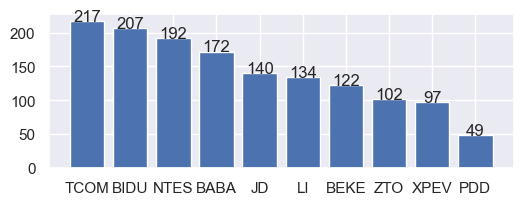

In [568]:
#showing the number of press releases by company
num_filings = dict()
for c in company:
    num_filings[c] = len(filings_all[filings_all['company'] == c])
num_filings_sorted = {k: v for k, v in sorted(num_filings.items(), 
                                              reverse = True, 
                                              key = lambda item: item[1])}
print_dict(num_filings_sorted)

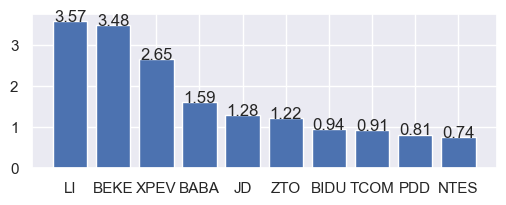

In [569]:
#showing the average number of press release per month by company
num_filings_per_month = dict()
for c in company:
    num_filings_per_month[c] = round(len(filings_all[filings_all['company'] == c]) / ((max(filings_all[filings_all["company"] == c]["date"]) - min(filings_all[filings_all["company"] == c]["date"])).days/30), 2)
    
num_filings_per_month_sorted = {k: v for k, v in sorted(num_filings_per_month.items(), 
                                              reverse = True, 
                                              key = lambda item: item[1])}
print_dict(num_filings_per_month_sorted)

In [493]:
def return_analysis(ticker):
    filing_app_dates = np.array(filings_all[filings_all["company"] == ticker]["app_date"])
    px = stock_price_all[ticker].dropna()
    vals = [(i in filing_app_dates) for i in px.index.values ]
    px['with_filing'] = vals
    return (
        np.mean(px['Returns']), np.mean(px[px['with_filing']]['Returns']), #avg return
        np.mean(np.abs(px['Returns'])), np.mean(np.abs(px[px['with_filing']]['Returns'])), #abs return
        np.mean(px['Volume']), np.mean(px[px['with_filing']]['Volume']) #volume
    )

In [500]:
avg_p = dict()
filing_p = dict()

avg_p_abs = dict()
filing_p_abs = dict()

avg_v = dict()
filing_v = dict()

for c in company:
    avg_p[c], filing_p[c], avg_p_abs[c], filing_p_abs[c], avg_v[c], filing_v[c] = return_analysis(c)

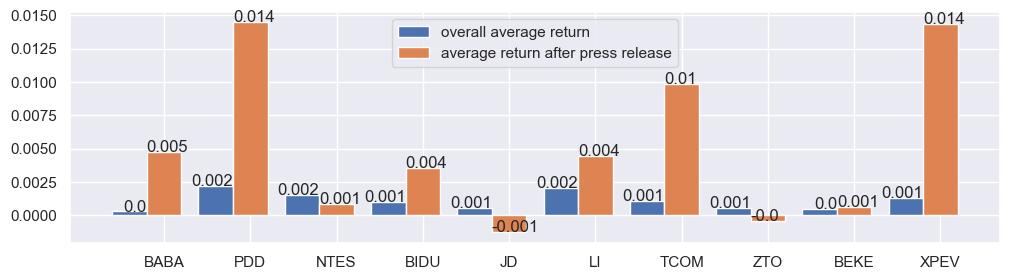

In [502]:
#plotting the avg return 
names = list(avg_p.keys())
values1 = list(avg_p.values())
values2 = list(filing_p.values())
plt.figure(figsize = (12, 3))

X_axis = np.arange(len(names))

plt.bar(X_axis - 0.2, values1, 0.4, tick_label=names, label = 'overall average return')
plt.bar(X_axis + 0.2, values2, 0.4, tick_label=names, label = 'average return after press release')

for i in range(len(names)):
    plt.text(i, values1[i], round(values1[i], 3), ha = 'right')
    plt.text(i, values2[i], round(values2[i], 3), ha = 'left')

plt.legend()    
plt.show()

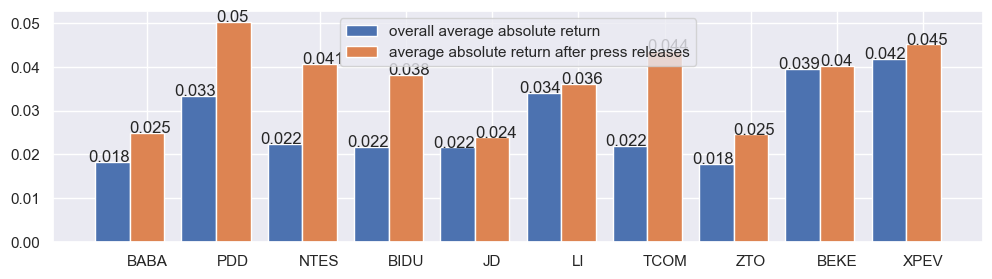

In [503]:
#plotting the avg return 
names = list(avg_p_abs.keys())
values1 = list(avg_p_abs.values())
values2 = list(filing_p_abs.values())
plt.figure(figsize = (12, 3))

X_axis = np.arange(len(names))

plt.bar(X_axis - 0.2, values1, 0.4, tick_label=names, label = 'overall average absolute return')
plt.bar(X_axis + 0.2, values2, 0.4, tick_label=names, label = 'average absolute return after press releases')

for i in range(len(names)):
    plt.text(i, values1[i], round(values1[i], 3), ha = 'right')
    plt.text(i, values2[i], round(values2[i], 3), ha = 'left')

plt.legend()
plt.show()

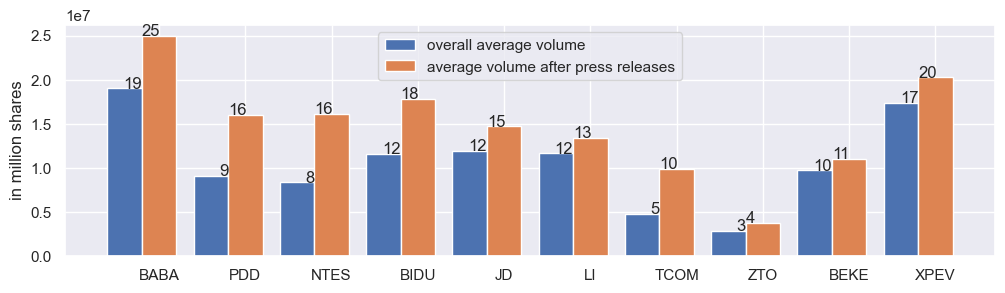

In [504]:
names = list(avg_v.keys())
values1 = list(avg_v.values())
values2 = list(filing_v.values())
plt.figure(figsize = (12, 3))

X_axis = np.arange(len(names))

plt.bar(X_axis - 0.2, values1, 0.4, tick_label=names, label = 'overall average volume')
plt.bar(X_axis + 0.2, values2, 0.4, tick_label=names, label = 'average volume after press releases')

for i in range(len(names)):
    plt.text(i, values1[i], round(values1[i]/1000000), ha = 'right')
    plt.text(i, values2[i], round(values2[i]/1000000), ha = 'left')

plt.ylabel("in million shares")
plt.legend()    
plt.show()

In [505]:
print("filing increases average absoulte price movement by:")
print(np.mean([i / j - 1 for i, j in zip(list(filing_p_abs.values()), list(avg_p_abs.values()))]))

print()

print("filing increases average daily trading volumn by:")
print(np.mean([i / j - 1 for i, j in zip(list(filing_v.values()), list(avg_v.values()))]))

filing increases average absoulte price movement by:
0.40933337144772886

filing increases average daily trading volumn by:
0.4662385770957469


In [570]:
q_p = dict()
non_q_p = dict()
q_v = dict()
non_q_v = dict()

for c in company:
    df = filings_all[filings_all["company"] == c]
    
    q_p[c] = np.mean(np.abs(df[df["quarterly"].values != None]["return"]))
    non_q_p[c] = np.mean(np.abs(df[df["quarterly"].values == None]["return"]))

    q_v[c] = np.mean(np.abs(df[df["quarterly"].values != None]["volume"]))
    non_q_v[c] = np.mean(np.abs(df[df["quarterly"].values == None]["volume"]))

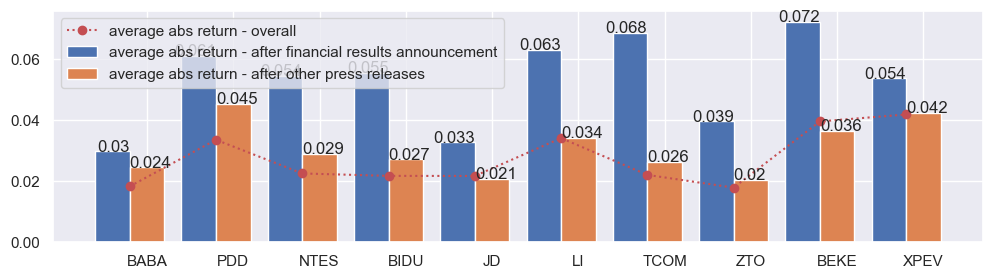

In [571]:
names = list(q_p.keys())
values1 = list(q_p.values())
values2 = list(non_q_p.values())

values3 = list(avg_p_dict.values())

plt.figure(figsize = (12, 3))

X_axis = np.arange(len(names))

plt.bar(X_axis - 0.2, values1, 0.4, tick_label=names, label = 'average abs return - after financial results announcement')
plt.bar(X_axis + 0.2, values2, 0.4, tick_label=names, label = 'average abs return - after other press releases')
plt.plot(values3, 'o:r', label = "average abs return - overall")

for i in range(len(names)):
    plt.text(i, values1[i], round(values1[i], 3), ha = 'right')
    plt.text(i, values2[i], round(values2[i], 3), ha = 'left')

plt.legend()
plt.show()

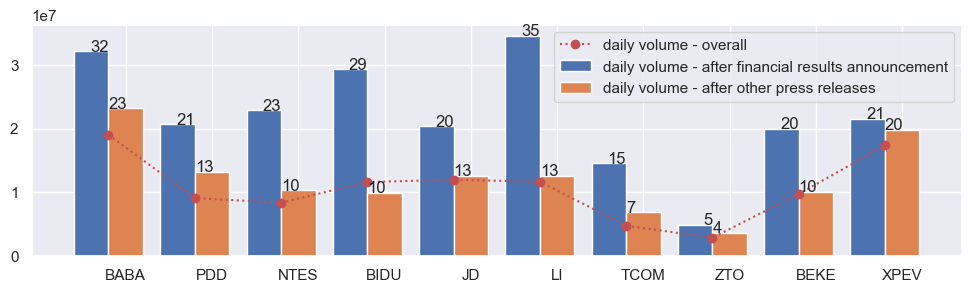

In [572]:
names = list(q_v.keys())
values1 = list(q_v.values())
values2 = list(non_q_v.values())

values3 = list(avg_v_dict.values())

plt.figure(figsize = (12, 3))

X_axis = np.arange(len(names))

plt.bar(X_axis - 0.2, values1, 0.4, tick_label=names, label = 'daily volume - after financial results announcement')
plt.bar(X_axis + 0.2, values2, 0.4, tick_label=names, label = 'daily volume - after other press releases')
plt.plot(values3, 'o:r', label = 'daily volume - overall')

for i in range(len(names)):
    plt.text(i, values1[i], round(values1[i]/1000000), ha = 'right')
    plt.text(i, values2[i], round(values2[i]/1000000), ha = 'left')

plt.ylabel("in million shares")
plt.legend()
plt.show()

In [573]:
print("quarterly results increases average absoulte price movement by:")
print(np.mean([i / j - 1 for i, j in zip(list(q_p.values()), list(avg_p_abs.values()))]))

print()

print("quarterly results increases average daily trading volumn by:")
print(np.mean([i / j - 1 for i, j in zip(list(q_v.values()), list(avg_v.values()))]))

quarterly results increases average absoulte price movement by:
1.0239566858615705

quarterly results increases average daily trading volumn by:
1.1991808252606266


In [653]:
#assessing the impact of absolute stock price movement after results announcement
def impact(item, n): #n is the number of days after the announcement
    impact_dict = dict()
    for c in company:
        df = filings_all[filings_all["company"] == c]
        app_date_q = list(df[df["quarterly"].values != None]["app_date"])

        overall_avg = []

        for i in range(len(stock_price_all[c])):
            if stock_price_all[c].iloc[i].name in app_date_q:
                avg = []
                for j in range(n):
                    try:
                        avg.append(abs(stock_price_all[c].iloc[i+j+1][item]))
                    except:
                        pass
                overall_avg.append(np.mean(avg))
        impact_dict[c] = np.mean(overall_avg)
    return impact_dict

In [635]:
q_p_1 = impact("Returns", 1)
q_p_3 = impact("Returns", 3)
q_p_5 = impact("Returns", 5)

In [654]:
q_v_1 = impact("Volume", 1)
q_v_3 = impact("Volume", 3)
q_v_5 = impact("Volume", 5)
q_v_10 = impact("Volume", 10)

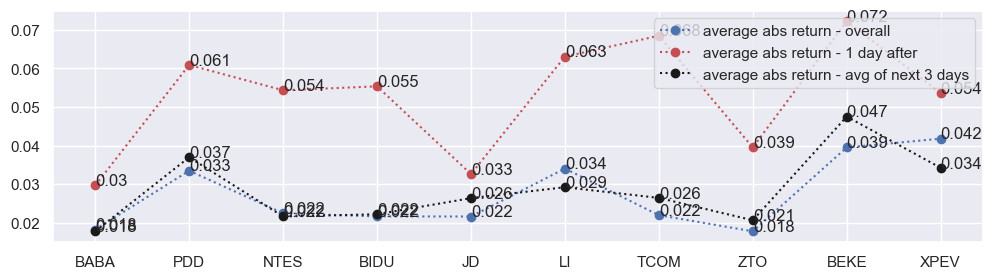

In [655]:
names = list(avg_p_abs.keys())
values1 = list(avg_p_abs.values())
values2 = list(q_p.values())
values3 = list(q_p_3.values())

plt.figure(figsize = (12, 3))

X_axis = np.arange(len(names))

plt.plot(values1, 'o:b', label = 'average abs return - overall')
plt.plot(values2, 'o:r', label = 'average abs return - 1 day after')
plt.plot(values3, 'o:k', label = 'average abs return - avg of next 3 days')

plt.xticks(X_axis, names)

for i in range(len(names)):
    plt.text(i, values1[i], round(values1[i], 3))
    plt.text(i, values2[i], round(values2[i], 3))
    plt.text(i, values3[i], round(values3[i], 3))
    
plt.legend(loc = "upper right")
plt.show()

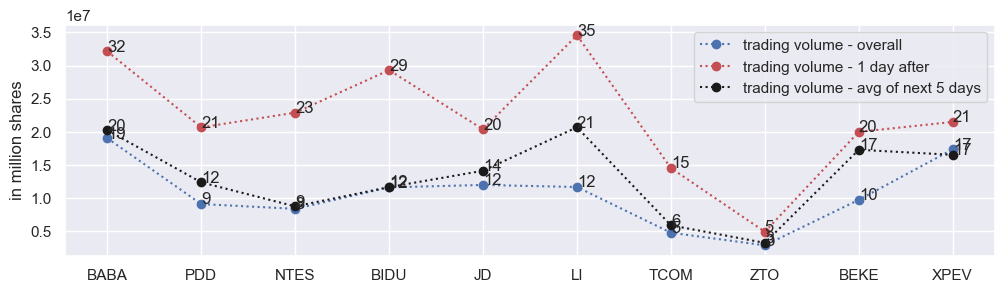

In [658]:
names = list(avg_v.keys())
values1 = list(avg_v.values())
values2 = list(q_v.values())
values3 = list(q_v_5.values())

plt.figure(figsize = (12, 3))

X_axis = np.arange(len(names))

plt.plot(values1, 'o:b', label = 'trading volume - overall')
plt.plot(values2, 'o:r', label = 'trading volume - 1 day after')
plt.plot(values3, 'o:k', label = 'trading volume - avg of next 5 days')

plt.xticks(X_axis, names)

for i in range(len(names)):
    plt.text(i, values1[i], round(values1[i]/1000000))
    plt.text(i, values2[i], round(values2[i]/1000000))
    plt.text(i, values3[i], round(values3[i]/1000000))

plt.ylabel("in million shares")
plt.legend()
plt.show()

In [660]:
print("average absoulte price movement: 3-days post announcement vs. average")
print(np.mean([i / j - 1 for i, j in zip(list(q_p_3.values()), list(avg_p_abs.values()))]))

print()

print("average absoulte price movement: 3-days post announcement vs. average")
print(np.mean([i / j - 1 for i, j in zip(list(q_v_3.values()), list(avg_v.values()))]))

average absoulte price movement: 3-days post announcement vs. average
0.0535357900010523

average absoulte price movement: 3-days post announcement vs. average
0.27468188325286225


In [95]:
#Naive Bayes model

In [668]:
df = filings_all

In [686]:
len(df[df["material_change"]==1]) / len(df)

0.5230446927374302

In [674]:
x = df['text'].values
y = df['material_change'].values

In [675]:
print(len(x))
print(len(y))

1432
1432


In [676]:
count_vector = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vector.fit(x)
x_transform = count_vector.transform(x)

In [685]:
count_vector.vocabulary_

{'alibaba': 144,
 'group': 533,
 'announces': 162,
 'proposed': 901,
 'offering': 798,
 'of': 795,
 'senior': 1033,
 'unsecured': 1181,
 'notes': 786,
 'supplemental': 1112,
 'information': 599,
 'relating': 956,
 'to': 1151,
 'unaudited': 1173,
 'interim': 616,
 'condensed': 310,
 'consolidated': 320,
 'financial': 484,
 'statements': 1085,
 'for': 497,
 'the': 1142,
 'six': 1061,
 'months': 758,
 'ended': 423,
 'september': 1035,
 '30': 69,
 '2013': 39,
 'and': 157,
 '2014': 40,
 'updated': 1186,
 'part': 833,
 'iii': 582,
 'item': 638,
 '18': 20,
 'from': 511,
 'company': 297,
 's': 1011,
 'annual': 163,
 'report': 965,
 'on': 803,
 'form': 499,
 '20': 27,
 'f': 467,
 'year': 1235,
 'march': 727,
 '31': 72,
 '2019': 45,
 'as': 183,
 'filed': 479,
 'with': 1223,
 'securities': 1029,
 'exchange': 445,
 'commission': 291,
 'june': 660,
 '5': 79,
 'ex': 443,
 '101': 6,
 'ins': 603,
 'xbrl': 1229,
 'taxonomy': 1124,
 'instance': 605,
 'document': 398,
 'sch': 1018,
 'extension': 464,
 's

In [680]:
x_train, x_test, y_train, y_test = train_test_split(x_transform, y, train_size=0.85, random_state=15)

In [697]:
model = naive_bayes.MultinomialNB()
model.fit(x_train, y_train)

predictions = model.predict(x_test)

In [698]:
predicted = model.predict(x_test)

In [699]:
print(metrics.accuracy_score(predicted, y_test))

0.6139534883720931


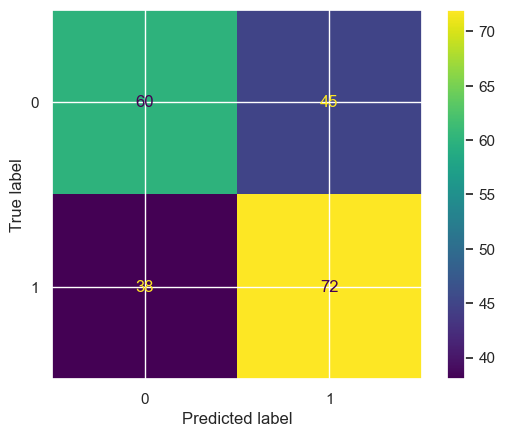

In [701]:
labels = [0, 1]
cm = confusion_matrix(y_test, predicted, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

In [740]:
#Frequency model

In [741]:
df = filings_all

In [742]:
freqs = create_freqs(df)
freqs_alternate = create_freqs_alternate(df)

In [743]:
n = len(df)

In [744]:
x = np.zeros((n, 3))
for i in range(n):
    x[i, :]= extract_features(_, freqs, df.iloc[i]['token_text'])
y = np.array(df['material_change'])

In [745]:
print(x.shape)
print(y.shape)

(1432, 3)
(1432,)


In [746]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.85, random_state=20)

In [747]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1217, 3)
(215, 3)
(1217,)
(215,)


In [748]:
reg = LogisticRegression()
reg.fit(x_train, y_train)

LogisticRegression()

In [749]:
print('training score:', reg.score(x_train, y_train))
print('testing score:', reg.score(x_test, y_test))

training score: 0.6253081347576006
testing score: 0.6046511627906976


In [760]:
f = freqs

words_neutral = {}
for row in f:
    w, n = row
    if n == 1:
        if w in words_neutral:
            words_neutral[w] += f[row]
        else:
            words_neutral[w] = f[row]
    else:
        if w in words_neutral:
            words_neutral[w] -= f[row]
        else:
            words_neutral[w] = -f[row]
freq_df = pd.DataFrame(list(words_neutral.items())).sort_values(by=1, ascending=False)
freq_df.columns = ['word', 'count']

In [767]:
company_full = ["alibaba", "pdd", "netease", "baidu", "jd", 
                "li", "trip", "zto", "beike", "xpeng"]

In [769]:
period = ["first", "second", "third", "fourth",
         "march", "june", "september", "december"]

In [770]:
for i in range(len(freq_df)):
    if freq_df["word"][i] in period:
        print(f"word: {freq_df['word'][i]}; count: {freq_df['count'][i]}")

word: march; count: 8
word: june; count: -4
word: second; count: 32
word: third; count: 55
word: fourth; count: 37
word: first; count: 35


In [775]:
freq_df[-20:]

,word,count
109,board,-10
112,servic,-10
451,due,-10
226,express,-11
120,1,-11
64,hold,-11
7,note,-12
4,offer,-12
305,record,-12
277,exhibit,-12


In [194]:
for i in range(10):
    df_sorted = df.sort_values(by="net_return_abs", ascending=False)
    x_temp = extract_features(_, freqs, df_sorted.iloc[i]['token_text'])
    print(df_sorted.iloc[i]['text'])
    print(df_sorted.iloc[i]['material_change'])
    print("predict:", reg.predict_proba(x_temp))
    print("actual (material change?):", df_sorted.iloc[i]['material_change'])
    print()

Baidu Announces First Quarter 2006 Results Strong Revenue and Earnings Growth Continues
1
predict: [[0.31462404 0.68537596]]
actual (material change?): 1

Press Release Regarding Third Quarter Results
1
predict: [[0.25685209 0.74314791]]
actual (material change?): 1

XPENG and the Volkswagen Group Announce Entry into Framework Agreement on Strategic Technical Collaboration and Strategic Minority Investment by the Volkswagen Group in XPENG
1
predict: [[0.53161679 0.46838321]]
actual (material change?): 1

Ctrip Reports First Quarter 2013 Financial Results
1
predict: [[0.23000467 0.76999533]]
actual (material change?): 1

Ctrip Reports Unaudited Fourth Quarter and Full Year 2014 Financial Results
1
predict: [[0.1906267 0.8093733]]
actual (material change?): 1

KE Holdings Inc. Announces Fourth Quarter and Fiscal Year 2021 Unaudited Financial Results
1
predict: [[0.23233109 0.76766891]]
actual (material change?): 1

Ctrip Reports Second Quarter 2008 Financial Results
1
predict: [[0.227780

In [62]:
#Archive codes for downloading filings and stock prices

In [63]:
#dl = Downloader("DavidLau", "davidlau512@gmail.com")
#dl.get("6-K", "NIO")

In [64]:
start = "2000-01-01"
end = "2023-10-16"

In [65]:
cs = ['BABA', 'PDD', 'NTES', 'BIDU', 'JD', 
           'LI', 'YUMC', 'TCOM', 'ZTO', 'BEKE', 
           'BGNE', 'XPEV', 'NIO']

In [66]:
for c in cs:
    df = yf.download(c, start, end, interval='1d')
    file_name = c + '.csv'
    df.to_csv(file_name)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [38]:
df = yf.download('^IXIC', start, end, interval='1d')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,4186.189941,4192.189941,3989.709961,4131.149902,4131.149902,1510070000
2000-01-04,4020.000000,4073.250000,3898.229980,3901.689941,3901.689941,1511840000
2000-01-05,3854.350098,3924.209961,3734.870117,3877.540039,3877.540039,1735670000
2000-01-06,3834.439941,3868.760010,3715.620117,3727.129883,3727.129883,1598320000
2000-01-07,3711.090088,3882.669922,3711.090088,3882.620117,3882.620117,1634930000
...,...,...,...,...,...,...
2023-10-09,13326.219727,13509.299805,13277.480469,13484.240234,13484.240234,3835930000
2023-10-10,13505.809570,13659.629883,13491.809570,13562.839844,13562.839844,4301350000
2023-10-11,13619.209961,13671.110352,13549.290039,13659.679688,13659.679688,4160440000


In [39]:
df.to_csv("nasdaq.csv")